In [1]:
import pandas as pd
import pymde
import scipy as sp
import lang2vec.lang2vec as l2v
import numpy as np

In [2]:
import torch

In [3]:
np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

In [4]:
languages = []
for lang in l2v.LANGUAGES:
    languages.append(str(lang))

In [5]:
l2v.LANGUAGES == l2v.available_languages()

True

In [50]:
feature_sets = l2v.FEATURE_SETS

In [51]:
feature_sets

['syntax_wals',
 'phonology_wals',
 'syntax_sswl',
 'syntax_ethnologue',
 'phonology_ethnologue',
 'inventory_ethnologue',
 'inventory_phoible_aa',
 'inventory_phoible_gm',
 'inventory_phoible_saphon',
 'inventory_phoible_spa',
 'inventory_phoible_ph',
 'inventory_phoible_ra',
 'inventory_phoible_upsid',
 'syntax_knn',
 'phonology_knn',
 'inventory_knn',
 'syntax_average',
 'phonology_average',
 'inventory_average',
 'fam',
 'id',
 'geo']

In [53]:
from iso639 import Lang
import iso639

In [56]:
feature_sets[-3]

'fam'

In [102]:
features = feature_sets[:13]
features.append(feature_sets[-3])
features

['syntax_wals',
 'phonology_wals',
 'syntax_sswl',
 'syntax_ethnologue',
 'phonology_ethnologue',
 'inventory_ethnologue',
 'inventory_phoible_aa',
 'inventory_phoible_gm',
 'inventory_phoible_saphon',
 'inventory_phoible_spa',
 'inventory_phoible_ph',
 'inventory_phoible_ra',
 'inventory_phoible_upsid',
 'fam']

In [103]:
features = l2v.get_features(languages, features)

In [104]:
for key, items in features.items():
    for i, item in enumerate(items):
        if item == '--':
            features[key][i] = 0

In [105]:
del_keys = []
for key, items in features.items():
    if items == [0] * len(items):
        del_keys.append(key)

In [106]:
for key in del_keys:
    del features[key]

In [107]:
lang_names = []
invalid = []
for key in features:
    try:
        lang = Lang(key)
        lang_names.append(lang.name)
    except iso639.exceptions.DeprecatedLanguageValue as e:
        err = str(e)
        index_1 = err.find('for')
        index_2 = err.find('is deprecated')
        lang = err[index_1:index_2].strip()
        lang_names.append(lang)
    except iso639.exceptions.InvalidLanguageValue as e:
        invalid.append(key)

In [108]:
for key in invalid:
    del features[key]

In [109]:
features_array = np.array(list(features.values()))
len(features_array)

3964

In [133]:
adjacency_matrix = sp.sparse.csr_matrix(np.array(list(features.values())))

In [157]:
graph = pymde.preprocess.k_nearest_neighbors(adjacency_matrix, k=30)

Sep 23 03:18:47 PM: Your dataset appears to contain duplicated items (rows); when embedding, you should typically have unique items.
Sep 23 03:18:47 PM: The following items have duplicates [   0    2    6   24   29   32   69   70   73   80   90  106  110  123
  154  165  169  196  200  201  207  209  217  218  221  225  237  241
  271  289  301  311  322  341  349  380  389  403  426  429  443  446
  474  513  516  533  558  560  570  577  578  582  583  591  614  623
  632  638  646  657  661  662  666  682  686  699  707  738  746  750
  758  773  803  808  810  829  853  856  857  858  859  896  900  902
  910  915  923  973  989  993 1001 1004 1007 1019 1021 1035 1058 1060
 1062 1066 1079 1097 1137 1158 1190 1193 1213 1225 1235 1237 1241 1257
 1269 1270 1275 1284 1294 1296 1307 1319 1320 1330 1339 1340 1345 1346
 1371 1379 1380 1382 1387 1397 1404 1405 1407 1424 1445 1461 1465 1481
 1483 1484 1485 1498 1505 1514 1517 1526 1536 1540 1549 1561 1564 1571
 1589 1592 1600 1604 1606 1635

In [181]:
mde = pymde.preserve_neighbors(graph, device='xpu:0', embedding_dim=3)

In [182]:
edges = graph.edges
edges = edges.to('xpu')
weights = graph.weights
weights = weights.to('xpu')

In [183]:
import torch

In [184]:
embedding = mde.embed(verbose=True, max_iter=2000, print_every=50)

Sep 23 03:24:13 PM: Fitting a centered embedding into R^3, for a graph with 3964 items and 98057 edges.
Sep 23 03:24:13 PM: `embed` method parameters: eps=1.0e-05, max_iter=2000, memory_size=10
Sep 23 03:24:13 PM: iteration 0000 | distortion 0.363158 | residual norm 0.0703462 | step length 0.322253 | percent change 0.0207879
Sep 23 03:24:16 PM: iteration 0050 | distortion 0.183494 | residual norm 0.00072472 | step length 1 | percent change 1.16932
Sep 23 03:24:19 PM: iteration 0100 | distortion 0.181672 | residual norm 0.000544074 | step length 1 | percent change 0.0442371
Sep 23 03:24:21 PM: iteration 0150 | distortion 0.181128 | residual norm 0.000153383 | step length 1 | percent change 0.234942
Sep 23 03:24:24 PM: iteration 0200 | distortion 0.180834 | residual norm 0.000143614 | step length 1 | percent change 0.149891
Sep 23 03:24:27 PM: iteration 0250 | distortion 0.180677 | residual norm 0.000103051 | step length 1 | percent change 0.192086
Sep 23 03:24:30 PM: iteration 0300 | di

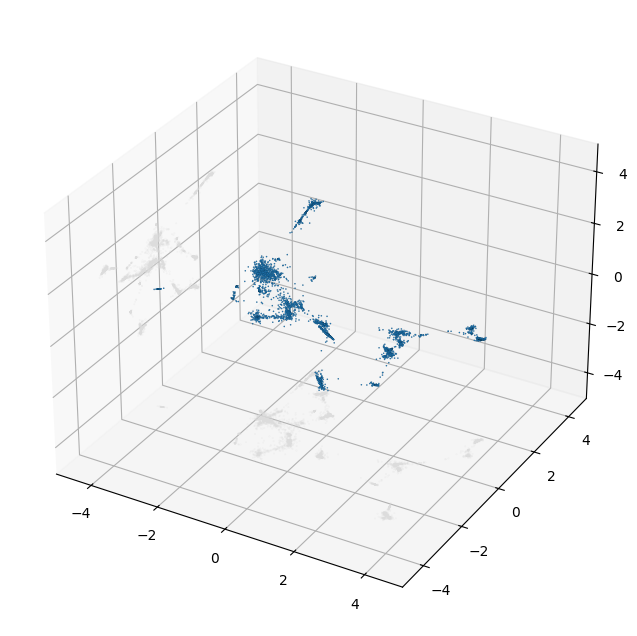

In [185]:
import matplotlib.pyplot as plt
mde.plot()
plt.show()

In [186]:
import emblaze

In [187]:
from emblaze.utils import Field, ProjectionTechnique

In [188]:
X = embedding.to('cpu')

In [189]:
emb = emblaze.Embedding({Field.POSITION: X, Field.COLOR: lang_names})

In [190]:
emb.compute_neighbors(metric='cosine')

In [191]:
variants = emblaze.EmbeddingSet([emb.project(method=ProjectionTechnique.UMAP) for _ in range(10)])

In [192]:
variants.compute_neighbors(metric='euclidean')

In [193]:
thumbnails = emblaze.TextThumbnails(lang_names)

In [194]:
for emb in variants.embeddings:
    emb.set_field(Field.NAME, lang_names)

In [195]:
w = emblaze.Viewer(embeddings=variants, thumbnails=thumbnails)
w

Viewer(colorScheme='tableau', data={'data': [{'_format': 'compressed', '_idtype': 'u2', '_length': 3964, 'ids'…

In [ ]:
w.save_comparison('visualisation.json')

: 